In [56]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)

from xgboost import XGBClassifier

In [47]:
df = pd.read_csv("transactions.csv")
df.head()


,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [48]:
df["transaction_time"] = pd.to_datetime(df["transaction_time"])

df["tx_hour"] = df["transaction_time"].dt.hour
df["tx_dayofweek"] = df["transaction_time"].dt.dayofweek  # 0 = lundi
df["tx_month"] = df["transaction_time"].dt.month

drop_cols = ["transaction_id", "user_id", "transaction_time"]
df_model = df.drop(columns=drop_cols)

df_model.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,shipping_distance_km,is_fraud,tx_hour,tx_dayofweek,tx_month
0,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,370.95,0,4,5,1
1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,149.62,0,20,1,1
2,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,164.08,0,6,4,1
3,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,397.40,0,17,0,1
4,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,935.28,0,1,2,1


In [49]:
X = df_model.drop (columns=["is_fraud"])
y = df_model["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [50]:
target = "is_fraud"

X = df_model.drop(columns=[target])
y = df_model[target]

cat_cols = [
    "country",
    "bin_country",
    "channel",
    "merchant_category",
    "promo_used",
    "avs_match",
    "cvv_result",
    "three_ds_flag",
]

num_cols = [col for col in X.columns if col not in cat_cols]

print("Colonnes catégorielles :", cat_cols)
print("Colonnes numériques :", num_cols)


Colonnes catégorielles : ['country', 'bin_country', 'channel', 'merchant_category', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']
Colonnes numériques : ['account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'shipping_distance_km', 'tx_hour', 'tx_dayofweek', 'tx_month']


In [51]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [52]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)

    # proba classe positive si possible
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
        pr = average_precision_score(y_test, y_proba)
    else:
        y_proba = None
        roc, pr = None, None

    print("\n" + "="*60)
    print(name)
    print("="*60)
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
    if roc is not None:
        print(f"ROC-AUC: {roc:.4f}")
        print(f"PR-AUC : {pr:.4f}")


In [53]:
log_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=3000, solver="saga"))
])

log_reg.fit(X_train, y_train)
evaluate_model(log_reg, X_test, y_test, "Logistic Regression - baseline")



Logistic Regression - baseline
Confusion matrix:
 [[58519    98]
 [  801   521]]

Classification report:
               precision    recall  f1-score   support

           0     0.9865    0.9983    0.9924     58617
           1     0.8417    0.3941    0.5368      1322

    accuracy                         0.9850     59939
   macro avg     0.9141    0.6962    0.7646     59939
weighted avg     0.9833    0.9850    0.9823     59939

ROC-AUC: 0.9380
PR-AUC : 0.6059


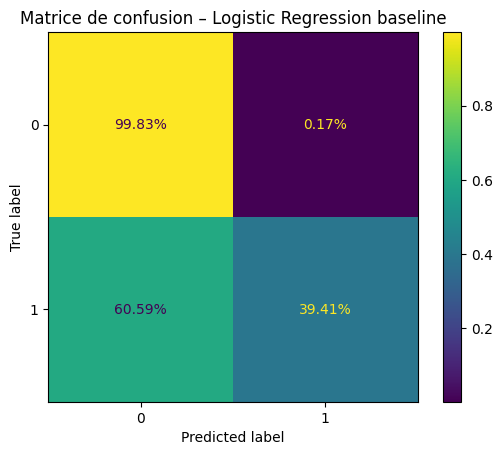

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    log_reg,
    X_test,
    y_test,
    normalize="true",  
    values_format=".2%"
)
plt.title("Matrice de confusion – Logistic Regression baseline")
plt.show()

In [58]:
rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest - baseline")



Random Forest - baseline
Confusion matrix:
 [[58549    68]
 [  428   894]]

Classification report:
               precision    recall  f1-score   support

           0     0.9927    0.9988    0.9958     58617
           1     0.9293    0.6762    0.7828      1322

    accuracy                         0.9917     59939
   macro avg     0.9610    0.8375    0.8893     59939
weighted avg     0.9913    0.9917    0.9911     59939

ROC-AUC: 0.9673
PR-AUC : 0.8372


In [ ]:
xgb = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test, "XGBoost - baseline")



XGBoost - baseline
Confusion matrix:
 [[58535    82]
 [  351   971]]

Classification report:
               precision    recall  f1-score   support

           0     0.9940    0.9986    0.9963     58617
           1     0.9221    0.7345    0.8177      1322

    accuracy                         0.9928     59939
   macro avg     0.9581    0.8665    0.9070     59939
weighted avg     0.9925    0.9928    0.9924     59939

ROC-AUC: 0.9767
PR-AUC : 0.8559


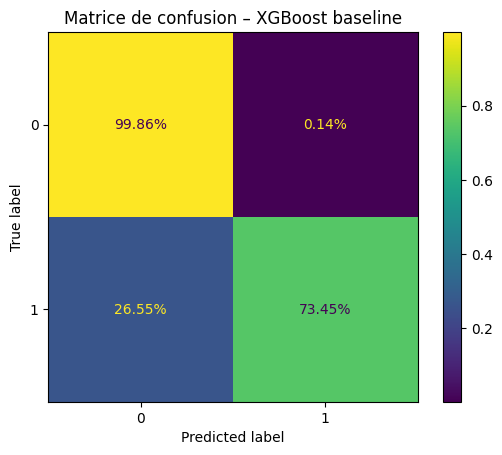

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    xgb,
    X_test,
    y_test,
    normalize="true",  
    values_format=".2%"
)
plt.title("Matrice de confusion – XGBoost baseline")
plt.show()

In [ ]:
class_weights = {0: 0.3, 1: 0.7}

In [ ]:
log_reg_w = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight=class_weights
    ))
])

log_reg_w.fit(X_train, y_train)
evaluate_model(log_reg_w, X_test, y_test, "Logistic Regression - class_weight")



Logistic Regression - class_weight
Confusion matrix:
 [[58334   283]
 [  659   663]]

Classification report:
               precision    recall  f1-score   support

           0     0.9888    0.9952    0.9920     58617
           1     0.7008    0.5015    0.5847      1322

    accuracy                         0.9843     59939
   macro avg     0.8448    0.7483    0.7883     59939
weighted avg     0.9825    0.9843    0.9830     59939

ROC-AUC: 0.9388
PR-AUC : 0.6020


In [ ]:
rf_w = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weights
    ))
])

rf_w.fit(X_train, y_train)
evaluate_model(rf_w, X_test, y_test, "Random Forest - class_weight")



Random Forest - class_weight
Confusion matrix:
 [[58550    67]
 [  437   885]]

Classification report:
               precision    recall  f1-score   support

           0     0.9926    0.9989    0.9957     58617
           1     0.9296    0.6694    0.7784      1322

    accuracy                         0.9916     59939
   macro avg     0.9611    0.8341    0.8870     59939
weighted avg     0.9912    0.9916    0.9909     59939

ROC-AUC: 0.9697
PR-AUC : 0.8380


In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight =", scale_pos_weight)

scale_pos_weight = 44.32249527410208


In [ ]:
xgb_w = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_w.fit(X_train, y_train)
evaluate_model(xgb_w, X_test, y_test, "XGBoost - scale_pos_weight")


XGBoost - scale_pos_weight
Confusion matrix:
 [[56641  1976]
 [  156  1166]]

Classification report:
               precision    recall  f1-score   support

           0     0.9973    0.9663    0.9815     58617
           1     0.3711    0.8820    0.5224      1322

    accuracy                         0.9644     59939
   macro avg     0.6842    0.9241    0.7520     59939
weighted avg     0.9834    0.9644    0.9714     59939

ROC-AUC: 0.9763
PR-AUC : 0.8476


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_args = dict(
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1
)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=3000, solver="saga"))
])


In [ ]:
param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__class_weight": [
        None,
        "balanced",
        {0: 0.3, 1: 0.7},
        {0: 0.2, 1: 0.8}
    ]
}


In [ ]:
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, **grid_args)
gs_lr.fit(X_train, y_train)
print("Best LR params:", gs_lr.best_params_)
print("Best LR PR-AUC:", gs_lr.best_score_)
best_lr = gs_lr.best_estimator_
evaluate_model(best_lr, X_test, y_test, "LogReg - best GridSearch")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\khouf\anaconda3\envs\base11\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Best LR params: {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2'}
Best LR PR-AUC: 0.6040534720924038

LogReg - best GridSearch
Confusion matrix:
 [[58519    98]
 [  801   521]]

Classification report:
               precision    recall  f1-score   support

           0     0.9865    0.9983    0.9924     58617
           1     0.8417    0.3941    0.5368      1322

    accuracy                         0.9850     59939
   macro avg     0.9141    0.6962    0.7646     59939
weighted avg     0.9833    0.9850    0.9823     59939

ROC-AUC: 0.9380
PR-AUC : 0.6059


In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [ ]:
param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 5],
    "model__class_weight": [
        None,
        "balanced",
        {0: 0.3, 1: 0.7}
    ]
}


In [ ]:
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, **grid_args)
gs_rf.fit(X_train, y_train)
print("Best RF params:", gs_rf.best_params_)
print("Best RF PR-AUC:", gs_rf.best_score_)
best_rf = gs_rf.best_estimator_
evaluate_model(best_rf, X_test, y_test, "RandomForest - best GridSearch")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best RF params: {'model__class_weight': None, 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400}
Best RF PR-AUC: 0.8387846692262414

RandomForest - best GridSearch
Confusion matrix:
 [[58556    61]
 [  437   885]]

Classification report:
               precision    recall  f1-score   support

           0     0.9926    0.9990    0.9958     58617
           1     0.9355    0.6694    0.7804      1322

    accuracy                         0.9917     59939
   macro avg     0.9641    0.8342    0.8881     59939
weighted avg     0.9913    0.9917    0.9910     59939

ROC-AUC: 0.9726
PR-AUC : 0.8414


In [ ]:
from xgboost import XGBClassifier

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = neg / pos
print("scale_pos_weight base:", spw)


scale_pos_weight base: 44.32249527410208


In [ ]:
pipe_xgb = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])


In [ ]:
param_grid_xgb = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__scale_pos_weight": [1, spw, spw * 0.7, spw * 1.3]
}


In [ ]:
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, **grid_args)
gs_xgb.fit(X_train, y_train)

print("Best XGB params:", gs_xgb.best_params_)
print("Best XGB PR-AUC:", gs_xgb.best_score_)
best_xgb = gs_xgb.best_estimator_
evaluate_model(best_xgb, X_test, y_test, "XGBoost - best GridSearch")


Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best XGB params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 600, 'model__scale_pos_weight': 1, 'model__subsample': 0.8}
Best XGB PR-AUC: 0.8526305835000896

XGBoost - best GridSearch
Confusion matrix:
 [[58540    77]
 [  363   959]]

Classification report:
               precision    recall  f1-score   support

           0     0.9938    0.9987    0.9963     58617
           1     0.9257    0.7254    0.8134      1322

    accuracy                         0.9927     59939
   macro avg     0.9598    0.8621    0.9048     59939
weighted avg     0.9923    0.9927    0.9922     59939

ROC-AUC: 0.9761
PR-AUC : 0.8535


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

def get_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
    else:
        roc_auc = None
        pr_auc = None

    return {
        "model": model_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision_fraud": precision_score(y_test, y_pred, pos_label=1),
        "recall_fraud": recall_score(y_test, y_pred, pos_label=1),
        "f1_fraud": f1_score(y_test, y_pred, pos_label=1),
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }


In [ ]:
results = []

In [ ]:
results.append(get_metrics(log_reg, X_test, y_test, "LogReg - baseline"))
results.append(get_metrics(log_reg_w, X_test, y_test, "LogReg - class_weight"))

results.append(get_metrics(rf, X_test, y_test, "RandomForest - baseline"))
results.append(get_metrics(rf_w, X_test, y_test, "RandomForest - class_weight"))

results.append(get_metrics(xgb, X_test, y_test, "XGBoost - baseline"))
results.append(get_metrics(xgb_w, X_test, y_test, "XGBoost - class_weight"))

results.append(get_metrics(best_lr, X_test, y_test, "LogReg - GridSearch"))
results.append(get_metrics(best_rf, X_test, y_test, "RandomForest - GridSearch"))
results.append(get_metrics(best_xgb, X_test, y_test, "XGBoost - GridSearch"))


In [ ]:
results_df = pd.DataFrame(results)
results_df

,model,accuracy,precision_fraud,recall_fraud,f1_fraud,roc_auc,pr_auc
0,LogReg - baseline,0.985001,0.841680,0.394100,0.536837,0.937979,0.605883
1,LogReg - class_weight,0.984284,0.700846,0.501513,0.584656,0.938812,0.601957
2,RandomForest - baseline,0.991725,0.929314,0.676248,0.782837,0.967314,0.837164
3,RandomForest - class_weight,0.991591,0.929622,0.669440,0.778364,0.969747,0.837999
4,XGBoost - baseline,0.992776,0.922127,0.734493,0.817684,0.976671,0.855920
5,XGBoost - class_weight,0.964431,0.371101,0.881997,0.522401,0.976288,0.847643
6,LogReg - GridSearch,0.985001,0.841680,0.394100,0.536837,0.937975,0.605881
7,RandomForest - GridSearch,0.991692,0.935518,0.669440,0.780423,0.972614,0.841434
8,XGBoost - GridSearch,0.992659,0.925676,0.725416,0.813401,0.976142,0.853535


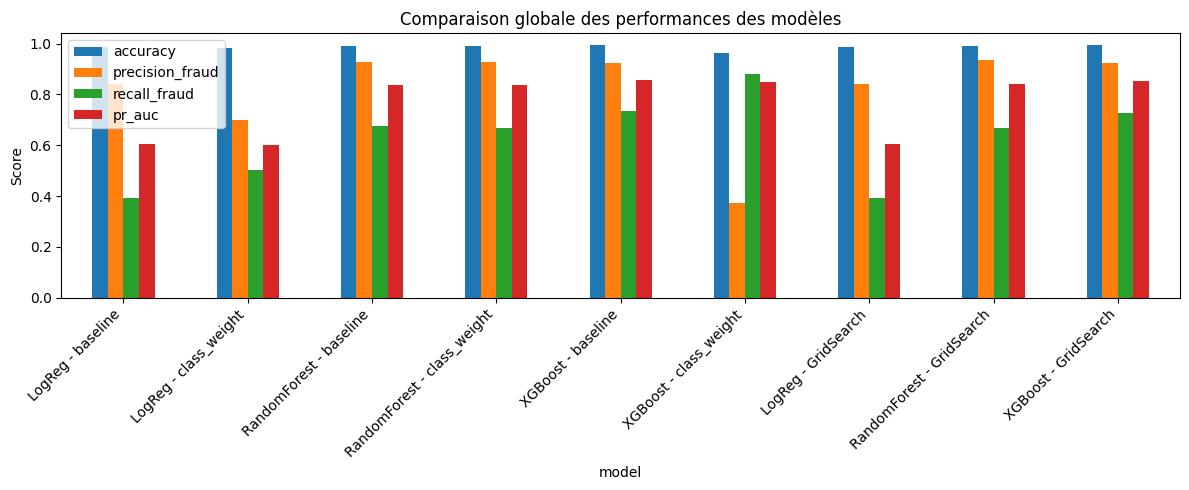

In [ ]:
import matplotlib.pyplot as plt

metrics = ["accuracy", "precision_fraud", "recall_fraud", "pr_auc"]

results_df.set_index("model")[metrics].plot(
    kind="bar",
    figsize=(12, 5)
)

plt.title("Comparaison globale des performances des modèles")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

##### Interprétation : 
Malgré de bonnes accuracies, les performances sur la détection de fraude restent limitées, notamment en termes de recall et de PR-AUC.

##### Graphique – Focus sur le recall fraude

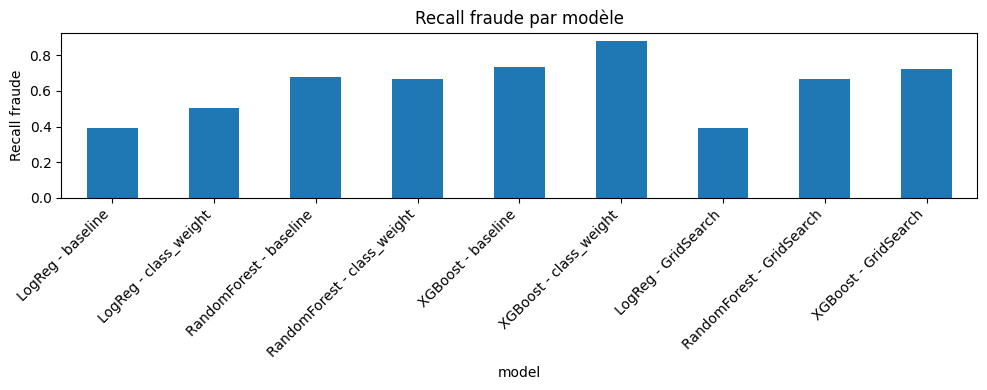

In [ ]:
plt.figure(figsize=(10,4))
results_df.set_index("model")["recall_fraud"].plot(kind="bar")
plt.title("Recall fraude par modèle")
plt.ylabel("Recall fraude")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

##### Interprétation : 
Les modèles baseline présentent un rappel fraude insuffisant, ce qui signifie qu’une grande partie des fraudes ne sont pas détectées.

##### Graphique – PR-AUC par modèle (DATASET DÉSÉQUILIBRÉ)

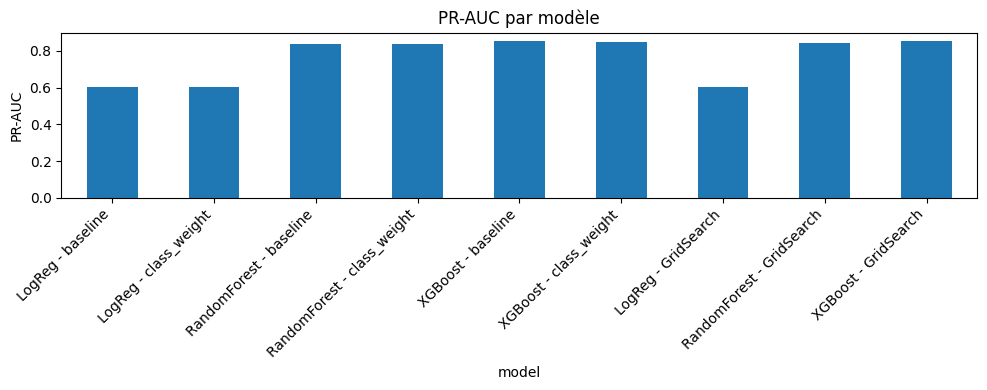

In [ ]:
plt.figure(figsize=(10,4))
results_df.set_index("model")["pr_auc"].plot(kind="bar")
plt.title("PR-AUC par modèle")
plt.ylabel("PR-AUC")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

##### Interprétation : 
La PR-AUC reste globalement faible, indiquant que les modèles ont des difficultés à distinguer les fraudes des transactions légitimes avec les features actuelles.

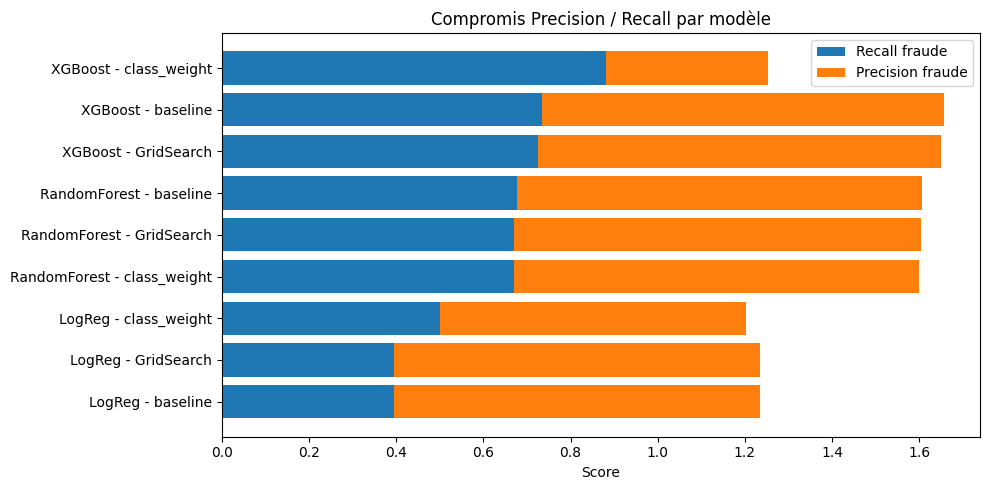

In [ ]:
import matplotlib.pyplot as plt

plot_df = results_df.copy()
plot_df = plot_df.sort_values("recall_fraud")

plt.figure(figsize=(10,5))
plt.barh(plot_df["model"], plot_df["recall_fraud"], label="Recall fraude")
plt.barh(plot_df["model"], plot_df["precision_fraud"], 
         left=plot_df["recall_fraud"], label="Precision fraude")

plt.xlabel("Score")
plt.title("Compromis Precision / Recall par modèle")
plt.legend()
plt.tight_layout()
plt.show()


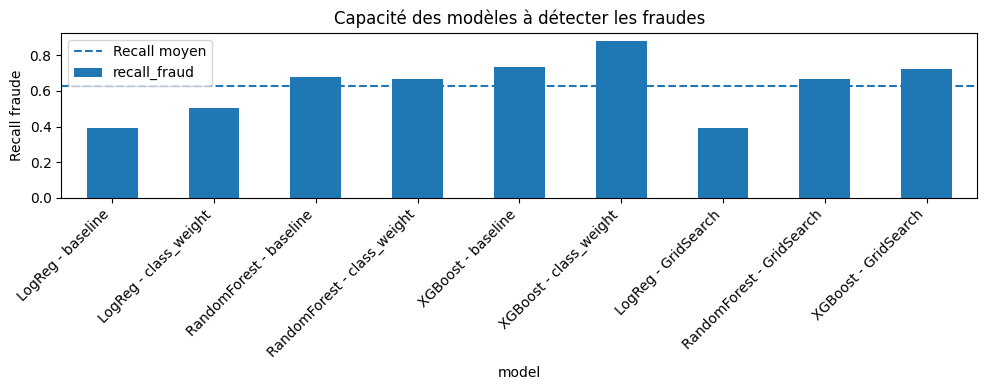

In [ ]:
plt.figure(figsize=(10,4))
results_df.set_index("model")["recall_fraud"].plot(kind="bar")

plt.axhline(
    y=results_df["recall_fraud"].mean(),
    linestyle="--",
    label="Recall moyen"
)

plt.ylabel("Recall fraude")
plt.title("Capacité des modèles à détecter les fraudes")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

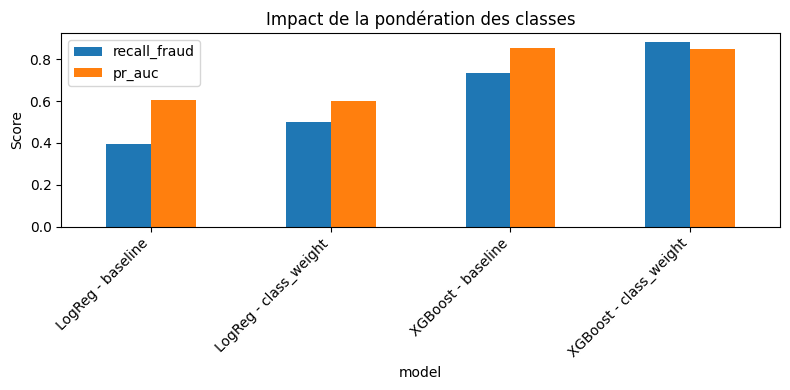

In [ ]:
subset = results_df[
    results_df["model"].isin([
        "LogReg - baseline",
        "LogReg - class_weight",
        "XGBoost - baseline",
        "XGBoost - class_weight"
    ])
]

subset.set_index("model")[["recall_fraud", "pr_auc"]].plot(
    kind="bar",
    figsize=(8,4)
)

plt.title("Impact de la pondération des classes")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
